#### Clustering: 
The goal is to group similar instances together into clusters. This is a great tool for data analysis, customer segmentation, recommender systems, search engines, image segmentation, semi-supervised learning, dimensionality reduction, and more.

#### Anomaly Detection:
The objective is to learn what "normal" data looks like, and use this to detect abnormal instances, such as defective items on a production line or a new trend in a time series.

#### Density Estimation:
This is the task of estimating the probability density function of the random process that generated the dataset. This is commonly used for anomaly detection: instances located in very low-density regions are likely to be anomalies. It is also useful for data analysis and visualization. 

### K-Means

In [2]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import numpy as np

blob_centers = np.array([[ 0.2,  2.3], [-1.5 ,  2.3], [-2.8,  1.8],
                         [-2.8,  2.8], [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std,
                  random_state=7)

k = 5
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
y_pred = kmeans.fit_predict(X)

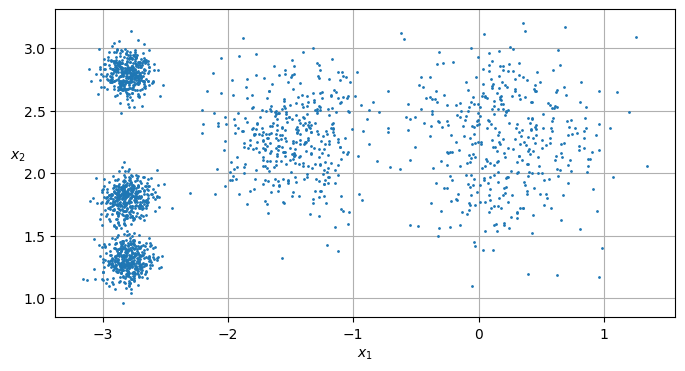

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.gca().set_axisbelow(True)
plt.grid()

plt.show()

In [4]:
y_pred

array([4, 0, 1, ..., 2, 1, 0])

In [5]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

In [6]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2])

In [7]:
kmeans.transform(X_new)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

The K-Means Algorithm works by randomly assinging the centroids and then label the instances and update the centroids and label the instance and so on until the centroids stop moving. The algorithm is guaranteed to converge in a finite number of steps, it will not oscillate forever.

Unfortunately, although the algorithm is guaranteed to converge, it may not converge to the right solution as this depends on the centroid intialization.


#### Centroid Initialization Methods

We can ran another clustering algorithm earlier and use the centroids using the init hyperparameter and set n_init to 1.

Another solution is to run the algorithm multiple times with different random initializations and keep the best solution. This is controlled by n_init. Default value is 10.

In [8]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)

KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, n_init=1, random_state=42)

#### Inertia

To select the best model, we will need a way to evaluate a K-Mean model's performance. Unfortunately, clustering is an unsupervised task, so we do not have the targets. But at least we can measure the distance between each instance and its centroid. 

In [9]:
kmeans.inertia_

211.5985372581684

The score() method returns the negative inertia because a predictor's score() method must always respect the "great is better" rule.

An important improvement to the K-Means algorithm, called K-Means++ introduced a smarter initialization step that tends to select centroids that are distant from one another, and this makes the K-Means algorithm much less likely to converge to a sub-optimal solution.

The KMeans class actually uses this initialization method by default. We can use the original method i.e. picking k instances randomly, by setting the init hyperparameter to random.


#### Accelerated K-Means and Mini-batch K-Means

We can accelerate the algorithm by avoiding unnecessary distance calculation (using triangle inequality) and by keeping track of lower and upper bounds for distances between instances and centroids. This is the algorithm used by the default KMeans class but we can use the original algorithm by setting the algorithm hyperparametr to full.

Instead of using the full dataset at each iteration, the algorithm is capable of using the mini-batches, moving the centroids just slighlty at each iteration. This speeds up the algorithm typically by a factor of 3 or 4. Scikit-Learn implements this algorithm in the MiniBatchKMeans class. 

In [11]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5)

In [12]:
minibatch_kmeans.inertia_

223.11220902975487

Mini-batch K-Means  algorithm is much faster than the regular K-Means algorithms, its inertia is generally slightly worse, especially as the number of clusters increases.


#### Finding the Optimal Number of Clusters

We cannot simply take the value of k that minimizes the inertia, since it keeps getting lower as we increase k. However, we can plot the inertia as a function of k and analyze the resulting curve.

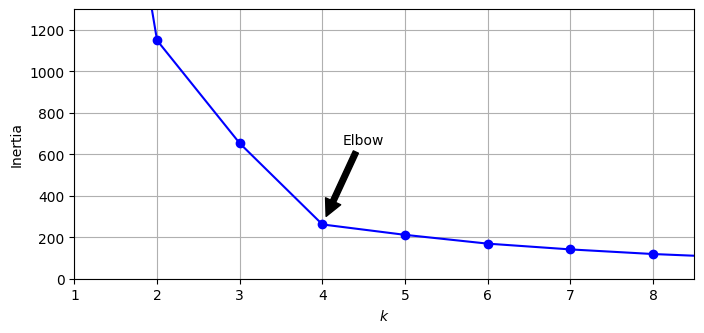

In [14]:
kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.annotate("", xy=(4, inertias[3]), xytext=(4.45, 650),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.text(4.5, 650, "Elbow", horizontalalignment="center")
plt.axis([1, 8.5, 0, 1300])
plt.grid()
plt.show()

But as we know there are 5 clusters, so this is also not good way.

Another approach is to look at the silhouette score, which is the mean silhouette coefficient over all the instances. An instance's silhouette coefficient is equal to (b - a) / max(a, b) where a is the mean distance to the other instances in the same cluster and b is the mean nearest-cluster distance. Silhouette coefficient close to +1 means that the instance is well inside its own cluster, while close to 0 means that it is close to a cluster boundary, and close to -1 means that the instance may have been assigned to the wrong cluster.

In [15]:
from sklearn.metrics import silhouette_score

In [16]:
silhouette_score(X, kmeans.labels_)

0.655517642572828